## **1D Wave Equation - Analytical Solution**  

The **1D Wave Equation** is given by:  

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, L], \quad t \geq 0
$$  

with the **initial conditions**:  

- **Initial displacement**:  
  $$
  u(x,0) = f(x)
  $$  
- **Initial velocity**:  
  $$
  \frac{\partial u}{\partial t} (x,0) = g(x)
  $$  

and **boundary conditions**:  

$$
u(0,t) = 0, \quad u(L,t) = 0
$$  

### **Analytical Solution**  

The general solution is:  

$$
u(x,t) = \sum_{n=1}^{\infty} \left[ A_n \cos\left(\frac{n\pi c}{L} t \right) + B_n \sin\left(\frac{n\pi c}{L} t \right) \right] \sin\left(\frac{n\pi}{L} x \right)
$$  

where the coefficients \( A_n \) and \( B_n \) are:  

$$
A_n = \frac{2}{L} \int_0^L f(x) \sin\left(\frac{n\pi}{L} x \right) dx
$$  

$$
B_n = \frac{2}{n\pi c} \int_0^L g(x) \sin\left(\frac{n\pi}{L} x \right) dx
$$  

For an initial condition  $$ ( f(x) = \sin\left(\frac{\pi}{L} x\right) ) $$ and **\( g(x) = 0 \)**, the solution simplifies to:  

$$
u(x,t) = \sin\left(\frac{\pi}{L} x \right) \cos\left(\frac{\pi c}{L} t \right)
$$  


In [1]:
import torch
import torch.nn as nn
import numpy as np

## Define the PINN Model

In [15]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)  # Combine x and t as input
        return self.net(inputs)

## Define the PDE residual loss

In [16]:
def pde_residual(x, t, model, c=1):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    return u_tt - (c**2) * u_xx

## Initialize model and optimizer

In [17]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    
    # Sample collocation points in the domain
    x_collocation = torch.rand(100, 1, requires_grad=True)
    t_collocation = torch.rand(100, 1, requires_grad=True)
    
    # Compute PDE residual loss
    loss_pde = torch.mean(pde_residual(x_collocation, t_collocation, model) ** 2)

    # Generate initial condition data
    x_ic = torch.rand(100, 1, requires_grad=True)  # Spatial points in (0,1)
    t_ic = torch.zeros_like(x_ic, requires_grad=True)  # Time = 0
    
    # Combine x and t into a single input tensor (shape: [100,2])
    X_ic = torch.cat((x_ic, t_ic), dim=1)  # Shape: (100,2)
    
    # Compute exact initial displacement and velocity
    u_ic = torch.sin(torch.pi * x_ic)  # f(x) = sin(pi * x)
    u_t_ic = torch.zeros_like(x_ic)  # g(x) = 0

    x_part, t_part = X_ic[:, 0:1], X_ic[:, 1:2]
    
    # Forward pass through the model
    u_pred = model(x_part, t_part)  # Model prediction for u(x,0)
    
    # Compute the time derivative ∂u/∂t using autograd
    u_t_pred = torch.autograd.grad(
        u_pred, X_ic,  # Differentiate w.r.t full input X_ic
        grad_outputs=torch.ones_like(u_pred), 
        create_graph=True, retain_graph=True
    )[0][:, 1:2]  # Extract time derivative component
    
    # Compute Mean Squared Error (MSE) loss for initial condition
    loss_u = nn.MSELoss()(u_pred, u_ic)  # Displacement loss
    loss_ut = nn.MSELoss()(u_t_pred, u_t_ic)  # Velocity loss
    loss_ic = loss_u + loss_ut

    # Enforce boundary conditions
    x_bc = torch.tensor([[0.0], [1.0]], requires_grad=True)  # x = 0 and x = 1
    t_bc = torch.rand(2, 1, requires_grad=True)  # Random time samples
    
    X_bc = torch.cat((x_bc, t_bc), dim=1)  # Shape: (2,2)
    x_bc_part, t_bc_part = X_bc[:, 0:1], X_bc[:, 1:2]
    u_bc_pred = model(x_bc_part, t_bc_part)  # Model prediction at boundaries
    u_bc_true = torch.zeros_like(u_bc_pred)  # u(0,t) = 0 and u(1,t) = 0
    
    loss_bc = nn.MSELoss()(u_bc_pred, u_bc_true)  # Boundary loss

    # Total loss
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")  


Epoch 0, Loss: 1.3061199188232422
Epoch 500, Loss: 0.1173967570066452
Epoch 1000, Loss: 0.05288626626133919
Epoch 1500, Loss: 0.014251301065087318
Epoch 2000, Loss: 0.016105270013213158
Epoch 2500, Loss: 0.015327205881476402
Epoch 3000, Loss: 0.007394406013190746
Epoch 3500, Loss: 0.007260479498654604
Epoch 4000, Loss: 0.005278721451759338
Epoch 4500, Loss: 0.0030041206628084183


## Evaluate the trained model

In [28]:
x_test = torch.linspace(0, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')  # Create a grid

X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

In [29]:
with torch.no_grad():
    U_flat = model(X_flat, T_flat)
U = U_flat.reshape(100, 100).numpy()  # Reshape into a 100x100 matrix

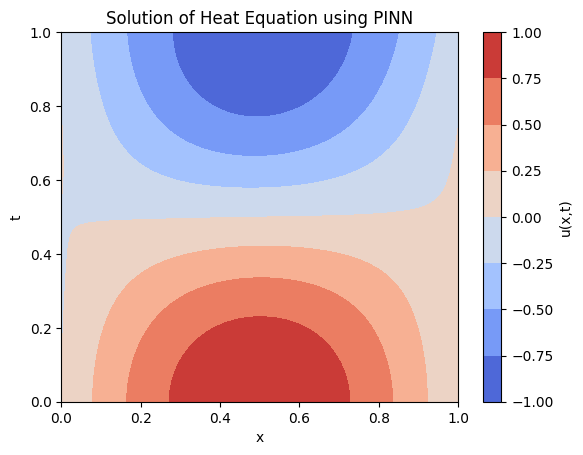

In [30]:
import matplotlib.pyplot as plt

plt.contourf(X.numpy(), T.numpy(), U, cmap="coolwarm")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Solution of Heat Equation using PINN")
plt.show()

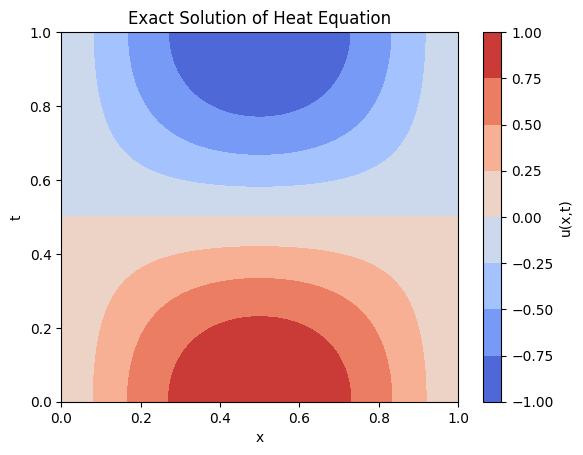

In [31]:
# Compute the exact solution
U_exact = np.sin(np.pi * X) * np.cos(np.pi * T)

# Plot the exact solution
plt.contourf(X, T, U_exact, cmap="coolwarm")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution of Heat Equation")
plt.show()

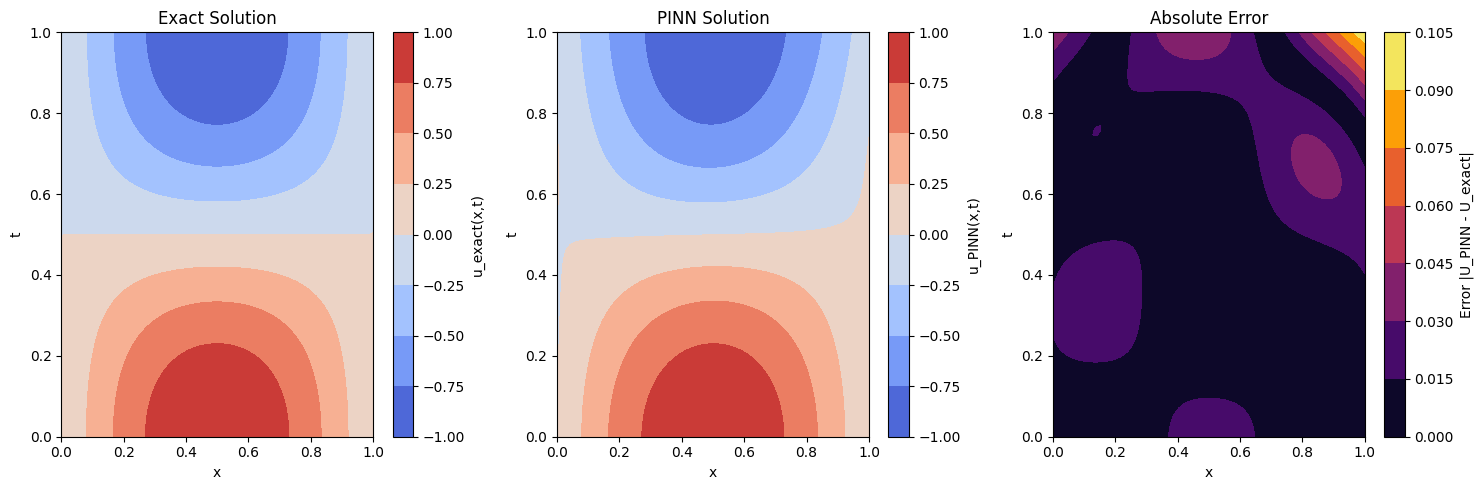

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution of the 1D heat equation
def exact_solution(x, t):
    return np.sin(np.pi * x) * np.cos(np.pi * t)

# Generate test data (x, t)
x_test = torch.linspace(0, 1, 100)
t_test = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x_test, t_test, indexing='ij')  # Meshgrid

# Convert to 1D for model input
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

# Evaluate PINN model on (x, t) grid
with torch.no_grad():
    U_PINN_flat = model(X_flat, T_flat)  # PINN output
U_PINN = U_PINN_flat.reshape(100, 100).numpy()  # Reshape for plotting

# Compute the exact solution
U_exact = exact_solution(X.numpy(), T.numpy())

# Compute the absolute error |U_PINN - U_exact|
error = np.abs(U_PINN - U_exact)

# Plot PINN Solution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), T.numpy(), U_exact, cmap="coolwarm")
plt.colorbar(label="u_exact(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution")

# Plot PINN Solution
plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), T.numpy(), U_PINN, cmap="coolwarm")
plt.colorbar(label="u_PINN(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution")

# Plot Error |U_PINN - U_exact|
plt.subplot(1, 3, 3)
plt.contourf(X.numpy(), T.numpy(), error, cmap="inferno")
plt.colorbar(label="Error |U_PINN - U_exact|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Absolute Error")

# Show the plots
plt.tight_layout()
plt.show()


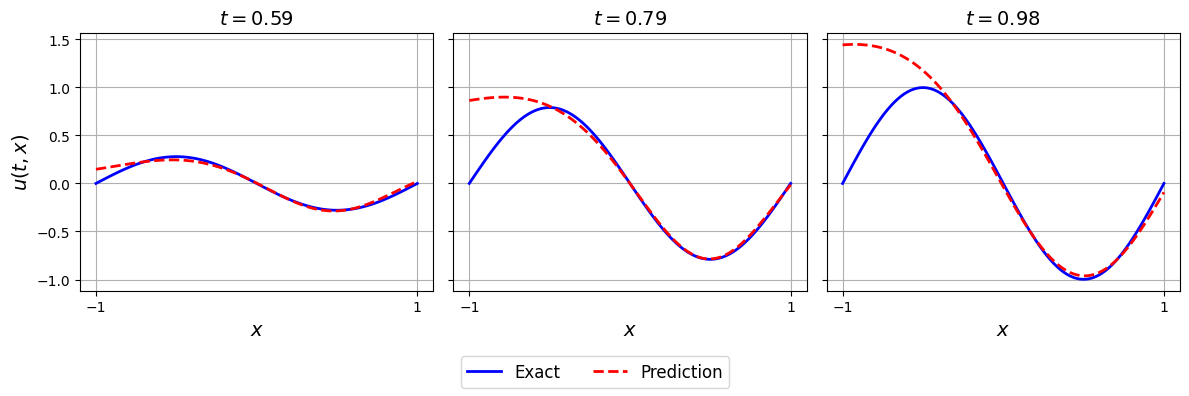

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution function
def exact_solution(x, t):
    return np.sin(np.pi * x) * np.cos(np.pi * t)

# Generate x values
x_test = torch.linspace(-1, 1, 100)  # Adjust the range if needed

# Choose specific time snapshots
time_snapshots = [0.59, 0.79, 0.98]

# Create subplots
fig, axes = plt.subplots(1, len(time_snapshots), figsize=(12, 4), sharey=True)

# Loop through each time snapshot
for i, t in enumerate(time_snapshots):
    t_fixed = torch.full_like(x_test, t)  # Create a tensor of the same shape with fixed time
    
    # Evaluate the PINN model at (x, t)
    with torch.no_grad():
        u_pred = model(x_test.view(-1, 1), t_fixed.view(-1, 1)).numpy().flatten()
    
    # Compute exact solution
    u_exact = exact_solution(x_test.numpy(), t)

    # Plot exact solution
    axes[i].plot(x_test.numpy(), u_exact, 'b-', linewidth=2, label="Exact")  # Blue solid line
    
    # Plot PINN predicted solution
    axes[i].plot(x_test.numpy(), u_pred, 'r--', linewidth=2, label="Prediction")  # Red dashed line
    
    # Labels and titles
    axes[i].set_title(r"$t = %.2f$" % t, fontsize=14)
    axes[i].set_xlabel(r"$x$", fontsize=14)
    axes[i].set_xticks([-1, 1])  # Adjust x-axis ticks for clarity
    
    if i == 0:
        axes[i].set_ylabel(r"$u(t,x)$", fontsize=14)  # Label for y-axis (only on the first plot)
    
    axes[i].grid(True)

# Add legend below the plots
fig.legend(["Exact", "Prediction"], loc="lower center", ncol=2, fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()
